WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set
C:\Users\HP\.astroNN\datasets\Galaxy10.h5 was found!
Epoch 1/25
200/200 [==============================] - 73s 339ms/step - loss: 2.2516 - accuracy: 0.3581 - val_loss: 7.4612 - val_accuracy: 0.3587
Epoch 2/25
200/200 [==============================] - 74s 370ms/step - loss: 1.6723 - accuracy: 0.4141 - val_loss: 2.3021 - val_accuracy: 0.3212
Epoch 3/25
200/200 [==============================] - 75s 377ms/step - loss: 1.6066 - accuracy: 0.4125 - val_loss: 1.6880 - val_accuracy: 0.3294
Epoch 4/25
200/200 [==============================] - 78s 391ms/step - loss: 1.5127 - accuracy: 0.4200 - val_loss: 1.4356 - val_accuracy: 0.4700
Epoch 5/25
200/200 [==============================] - 75s 376ms/step - loss: 1.4270 - accuracy: 0.4417 - val_loss: 1.4187 - val_accuracy: 0.4869
Epoch 6/25
200/200 [==============================] - 75s 374ms/step - loss: 1.4000 - accuracy: 

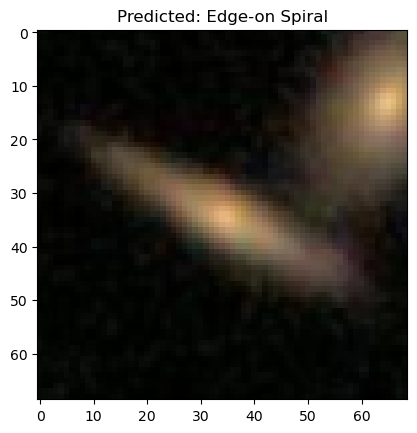

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from astroNN.datasets import load_galaxy10  # Install via pip install astroNN

# Load Galaxy10 dataset
X, y = load_galaxy10()

# Normalize images
X = X / 255.0

# Reduce dataset size for faster execution
X, y = X[:8000], y[:8000]  # Increased dataset size for better learning

# 🔹 Remap labels from 10 classes → 6 classes
def remap_labels(y):
    new_y = np.zeros_like(y)
    for i in range(len(y)):
        if y[i] == 1:
            new_y[i] = 0  # Round Elliptical
        elif y[i] == 2:
            new_y[i] = 1  # In-between Elliptical
        elif y[i] == 3:
            new_y[i] = 2  # Cigar-shaped Elliptical
        elif y[i] in [4, 5, 6]:  
            new_y[i] = 3  # Edge-on Spiral
        elif y[i] == 0:
            new_y[i] = 4  # Unbarred Spiral
        elif y[i] in [7, 8, 9]:  
            new_y[i] = 5  # Barred Spiral
    return new_y

y = remap_labels(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation for better generalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Learning rate scheduler
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=5000, alpha=0.0001
)

# Define Optimized CNN Model
model = keras.Sequential([
    data_augmentation,  # Apply data augmentation

    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(69, 69, 3), kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),  # Dropout for better generalization
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')  # 6 classes
])

# Compile Model with optimized Adam
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Train Model with more epochs
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=32)

# Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"🔹 Final Test Accuracy: {acc:.4f}")  

# Label names
labels = ["Round Elliptical", "In-between Elliptical", "Cigar-shaped Elliptical", 
          "Edge-on Spiral", "Unbarred Spiral", "Barred Spiral"]

# Predict on a test image
plt.imshow(X_test[0])
predicted_label = np.argmax(model.predict(X_test[:1]))  # Get the highest probability class
plt.title(f"Predicted: {labels[predicted_label]}")
plt.show()


In [2]:
model.save("galaxy_classifierrr.h5")


1/1 [==============================] - 0s 35ms/step


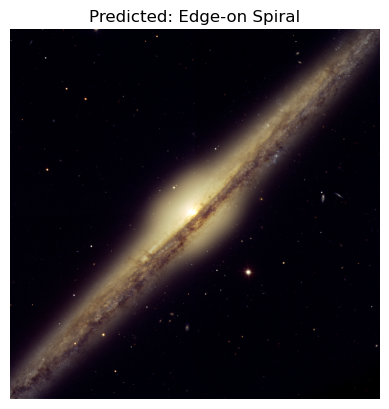

In [9]:
import numpy as np
import cv2  # Install via pip install opencv-python
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
#model = load_model("galaxy_classifier.h5")  # If you saved your trained model

# Define label names
labels = ["Round Elliptical", "In-between Elliptical", "Cigar-shaped Elliptical",
          "Edge-on Spiral", "Unbarred Spiral", "Barred Spiral"]

# 🔹 Load and preprocess the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (69, 69))  # Resize to match model input shape
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# 🔹 Test the model with an input image
def predict_image(image_path):
    img = preprocess_image(image_path)  # Preprocess image
    prediction = model.predict(img)  # Get predictions
    predicted_label = labels[np.argmax(prediction)]  # Get highest probability class

    # 🔹 Show the image with the predicted label
    plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# 🔹 Run prediction on your image
image_path = "E:\SEDS\eso0525a.jpg"  # Change this to your image file
predict_image(image_path)